In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [3]:
baseline_file = get_baseline()
runName = os.path.split(baseline_file)[-1].replace('.db', '')

opsdb = maf.OpsimDatabase(baseline_file)
print(runName)

baseline_v2.0_10yrs


In [4]:
threshold = 2.2
m = maf.AGN_TimeLagMetric(threshold=threshold, z=1, lag=100)
s = maf.HealpixSlicer(nside=64, useCache=False)
sql = ''
summaryMetrics = maf.extendedSummary()
summaryMetrics += [maf.AreaThresholdMetric(lower_threshold = threshold)]
plotDict = {'percentileClip': 98, 'figsize': (8, 5)}

bundle = maf.MetricBundle(m, s, sql, runName=runName, summaryMetrics=summaryMetrics, plotDict=plotDict)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [5]:
g = maf.MetricBundleGroup({'TimeLag': bundle}, opsdb, 'temp', None)
g.runAll()

Querying database observations with no constraint for columns ['fiveSigmaDepth', 'fieldDec', 'fieldRA', 'observationStartMJD', 'filter', 'rotSkyPos'].
Found 2086980 visits
Running:  ['TimeLag']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/maps/dustMap.py:26: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


0.0 180.0 -180.0 180.0
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 66039 bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

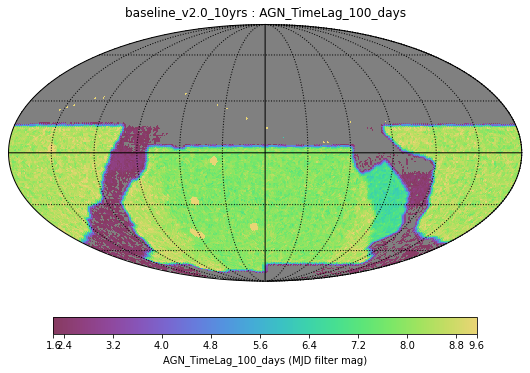

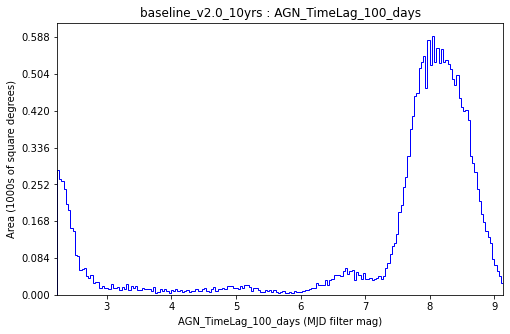

In [6]:
bundle.plot()

In [7]:
bundle.summaryValues

{'Mean': 8.653201071339616,
 'Rms': 49.062218318444025,
 'Median': 8.013565475086253,
 'Max': 3722.322529605523,
 'Min': 2.20021709290475,
 'N(+3Sigma)': 35,
 'N(-3Sigma)': 0,
 'Count': 27103,
 '25th%ile': 7.533570889227895,
 '75th%ile': 8.379620891264237,
 'AreaThreshold': 22747.375666158252}